<a href="https://colab.research.google.com/github/CescaNeri/ML-stocks-prediction/blob/main/stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install yfinance --upgrade --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 11.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [ ]:
stock = 'NVDA'

nvidia = yf.Ticker(stock)
nvidia = nvidia.history(period='max')

nvidia

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1999-01-22 00:00:00-05:00,0.401619,0.448236,0.356198,0.376518,271468800.0,0.0,0.0
1999-01-25 00:00:00-05:00,0.406400,0.420744,0.376518,0.415963,51048000.0,0.0,0.0
1999-01-26 00:00:00-05:00,0.420744,0.429111,0.377713,0.383690,34320000.0,0.0,0.0
1999-01-27 00:00:00-05:00,0.384885,0.394448,0.363370,0.382495,24436800.0,0.0,0.0
1999-01-28 00:00:00-05:00,0.382495,0.384885,0.378908,0.381300,22752000.0,0.0,0.0
...,...,...,...,...,...,...,...
2022-11-09 00:00:00-05:00,141.619995,142.110001,137.589996,137.759995,45441400.0,0.0,0.0
2022-11-10 00:00:00-05:00,148.000000,157.729996,145.470001,157.500000,70081900.0,0.0,0.0
2022-11-11 00:00:00-05:00,158.070007,163.889999,154.820007,163.270004,65503700.0,0.0,0.0


In [ ]:
nvidia.index

DatetimeIndex(['1999-01-22 00:00:00-05:00', '1999-01-25 00:00:00-05:00',
               '1999-01-26 00:00:00-05:00', '1999-01-27 00:00:00-05:00',
               '1999-01-28 00:00:00-05:00', '1999-01-29 00:00:00-05:00',
               '1999-02-01 00:00:00-05:00', '1999-02-02 00:00:00-05:00',
               '1999-02-03 00:00:00-05:00', '1999-02-04 00:00:00-05:00',
               ...
               '2022-11-02 00:00:00-04:00', '2022-11-03 00:00:00-04:00',
               '2022-11-04 00:00:00-04:00', '2022-11-07 00:00:00-05:00',
               '2022-11-08 00:00:00-05:00', '2022-11-09 00:00:00-05:00',
               '2022-11-10 00:00:00-05:00', '2022-11-11 00:00:00-05:00',
               '2022-11-14 00:00:00-05:00', '2022-11-15 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=5996, freq=None)

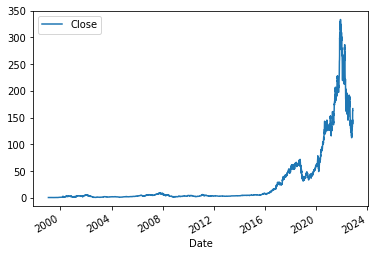

In [ ]:
nvidia.plot.line(y='Close', use_index=True)

In [ ]:
del nvidia['Dividends']
del nvidia['Stock Splits']

In [ ]:
nvidia['t1'] = nvidia['Close'].shift(-1)

In [ ]:
nvidia

,Open,High,Low,Close,Volume,t1
Date,,,,,,
1999-01-22 00:00:00-05:00,0.401619,0.448236,0.356198,0.376518,271468800.0,0.415963
1999-01-25 00:00:00-05:00,0.406400,0.420744,0.376518,0.415963,51048000.0,0.383690
1999-01-26 00:00:00-05:00,0.420744,0.429111,0.377713,0.383690,34320000.0,0.382495
1999-01-27 00:00:00-05:00,0.384885,0.394448,0.363370,0.382495,24436800.0,0.381300
1999-01-28 00:00:00-05:00,0.382495,0.384885,0.378908,0.381300,22752000.0,0.363370
...,...,...,...,...,...,...
2022-11-09 00:00:00-05:00,141.619995,142.110001,137.589996,137.759995,45441400.0,157.500000
2022-11-10 00:00:00-05:00,148.000000,157.729996,145.470001,157.500000,70081900.0,163.270004
2022-11-11 00:00:00-05:00,158.070007,163.889999,154.820007,163.270004,65503700.0,162.949997


In [ ]:
nvidia['Target'] = (nvidia['t1'] > nvidia['Close']).astype(int)

In [ ]:
nvidia

,Open,High,Low,Close,Volume,t1,Target
Date,,,,,,,
1999-01-22 00:00:00-05:00,0.401619,0.448236,0.356198,0.376518,271468800.0,0.415963,1
1999-01-25 00:00:00-05:00,0.406400,0.420744,0.376518,0.415963,51048000.0,0.383690,0
1999-01-26 00:00:00-05:00,0.420744,0.429111,0.377713,0.383690,34320000.0,0.382495,0
1999-01-27 00:00:00-05:00,0.384885,0.394448,0.363370,0.382495,24436800.0,0.381300,0
1999-01-28 00:00:00-05:00,0.382495,0.384885,0.378908,0.381300,22752000.0,0.363370,0
...,...,...,...,...,...,...,...
2022-11-09 00:00:00-05:00,141.619995,142.110001,137.589996,137.759995,45441400.0,157.500000,1
2022-11-10 00:00:00-05:00,148.000000,157.729996,145.470001,157.500000,70081900.0,163.270004,1
2022-11-11 00:00:00-05:00,158.070007,163.889999,154.820007,163.270004,65503700.0,162.949997,0


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

In [ ]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

In [ ]:
nvidia = nvidia.drop('2001-09-12 00:00:00-04:00')

In [ ]:
train = nvidia.iloc[:-100]
test = nvidia.iloc[-100:]

predictors = ['Close', 'Volume', 'Open', 'High', 'Low']

model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [ ]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index = test.index)

In [ ]:
precision_score(test['Target'], preds)

0.5483870967741935

In [ ]:
combined = pd.concat([test['Target'], preds], axis=1)

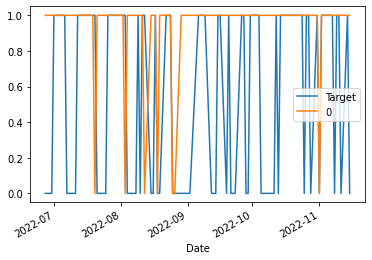

In [ ]:
combined.plot()

In [ ]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train['Target'])
  preds = model.predict(test[predictors])
  preds = pd.Series(preds, index = test.index, name = 'Predictions')
  combined = pd.concat([test['Target'], preds], axis = 1)
  return combined

In [ ]:
def backtest(data, model, predictors, start=2500, step=250):
  all_predictions = []

  for i in range(start, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i + step)].copy()
    predictions = predict(train, test, predictors, model)
    all_predictions.append(predictions)
  return pd.concat(all_predictions)

In [ ]:
predictions = backtest(nvidia, model, predictors)

In [ ]:
predictions['Predictions'].value_counts()

0    1970
1    1525
Name: Predictions, dtype: int64

In [ ]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5219672131147541

In [ ]:
predictions['Target'].value_counts() / predictions.shape[0]

1    0.526753
0    0.473247
Name: Target, dtype: float64

In [ ]:
horizons = [2, 5, 60, 250, 1000]

In [ ]:
new_predictors = []

for horizon in horizons:
  rolling_averages = nvidia.rolling(horizon).mean()

  ratio_column = f'Close_Ratio_{horizon}'
  nvidia[ratio_column] = nvidia['Close'] / rolling_averages['Close']

  trend_column = f'Trend_{horizon}'
  nvidia[trend_column] = nvidia.shift(1).rolling(horizon).sum()['Target']

  new_predictors += [ratio_column, trend_column]

In [ ]:
nvidia = nvidia.dropna()

In [ ]:
nvidia

,Open,High,Low,Close,Volume,t1,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2003-01-15 00:00:00-05:00,0.946291,0.953942,0.916457,0.916457,90458400.0,0.854492,0,0.984388,1.0,0.979718,3.0,0.906374,32.0,0.453887,104.0,0.474866,470.0
2003-01-16 00:00:00-05:00,0.902687,0.914162,0.842253,0.854492,203997600.0,0.822363,0,0.965011,0.0,0.928512,2.0,0.844112,31.0,0.426601,104.0,0.442659,469.0
2003-01-17 00:00:00-05:00,0.831543,0.843018,0.811654,0.822363,105883200.0,0.801708,0,0.980839,0.0,0.918332,1.0,0.812209,30.0,0.413813,104.0,0.425918,469.0
2003-01-21 00:00:00-05:00,0.837663,0.855258,0.799413,0.801708,96735600.0,0.802474,1,0.987282,0.0,0.923511,1.0,0.792348,29.0,0.406732,103.0,0.415130,469.0
2003-01-22 00:00:00-05:00,0.799413,0.823129,0.797118,0.802474,55099200.0,0.824658,1,1.000477,1.0,0.955896,1.0,0.793075,30.0,0.410636,103.0,0.415436,470.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-08 00:00:00-05:00,148.009995,148.910004,142.160004,146.020004,59529200.0,137.759995,0,1.010414,2.0,1.047504,4.0,1.058747,31.0,0.709271,122.0,1.150850,542.0
2022-11-09 00:00:00-05:00,141.619995,142.110001,137.589996,137.759995,45441400.0,157.500000,1,0.970893,1.0,0.980414,4.0,1.005047,31.0,0.671313,121.0,1.084878,542.0
2022-11-10 00:00:00-05:00,148.000000,157.729996,145.470001,157.500000,70081900.0,163.270004,1,1.066856,1.0,1.084935,4.0,1.152678,32.0,0.769700,122.0,1.239157,542.0


In [ ]:
model = RandomForestClassifier(n_estimators = 200, min_samples_split = 50, random_state = 1)

In [ ]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train['Target'])
  preds = model.predict_proba(test[predictors])[:,1]
  preds[preds >= .6] = 1
  preds[preds < .6] = 0
  preds = pd.Series(preds, index = test.index, name = 'Predictions')
  combined = pd.concat([test['Target'], preds], axis = 1)
  return combined

In [ ]:
predictions = backtest(nvidia, model, new_predictors)

In [ ]:
predictions['Predictions'].value_counts()

0.0    2301
1.0     193
Name: Predictions, dtype: int64

In [ ]:
precision_score(predictions['Target'], predictions['Predictions'])

0.5854922279792746